In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import shutil
import os
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
from tqdm import tqdm
import seaborn as sns

In [2]:
# CloudVolume and Cave setup
from cloudvolume import CloudVolume
from caveclient import CAVEclient
 
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))
client = CAVEclient('zheng_ca3')
auth = client.auth

import pcg_skel

In [3]:
# Read synapses as chunked data

df = pd.read_csv("inhibitorycells_3 - 11.inhibitory_cells.csv")

df.head()

,index,segid (Nuclei table segID),x,y,z,nuclear size,Coordinates,Coordinates (value only),Proofreader,Start Time,...,output_pyr,input_preference,output_preference,large_nuclues,small_nuclues,thorny,sparse_thorny,superficial (<40),deep (>40),large-small
0,122.0,7.339611e+16,59664,66848,895,274950.0,"59664, 66848, 895","59664, 66848, 895",John David,10/3/2024 0:01:44,...,1785.0,NaN,NaN,1171,276,377,62,394,492,895
1,164.0,7.290277e+16,45488,44268,605,176736.0,"45488, 44268, 605","45488, 44268, 605",Renzo,10/2/2024 21:03:46,...,1417.0,NaN,NaN,801,257,270,128,382,888,544
2,192.0,7.325510e+16,55696,57968,2050,165604.0,"55696, 57968, 2050","55696, 57968, 2050",Enriq,10/2/2024 17:19:32,...,458.0,NaN,NaN,291,52,115,22,182,192,239
3,24.0,7.248091e+16,33074,54653,1750,200691.0,"33074, 54653, 1750","33074, 54653, 1750",Brion,10/1/2024 19:16:32,...,645.0,NaN,NaN,369,137,157,16,303,121,232
4,183.0,7.311429e+16,52576,55776,378,161154.0,"52576, 55776, 378","52576, 55776, 378",Jansen,10/2/2024 19:16:28,...,690.0,NaN,NaN,366,134,62,59,53,520,232


In [6]:
def process_data(df):
    # Remove rows with "undecidable" in either "output_layer" or "input_layer"
    df_filtered = df[(df['output_layer'] != 'undecidable') & (df['input_layer'] != 'undecidable')]

    # Drop 'output_anyseg' and 'output_py' from the DataFrame
    df_filtered = df_filtered.drop(columns=['output_anyseg', 'output_pyr'])

    # Define the columns to normalize, excluding 'output_anyseg' and 'output_py'
    output_columns = ['output_oriens', 'output_pyramidal', 'output_lucidum', 'output_radiatum']
    input_columns = ['input_oriens', 'input_pyramidal', 'input_lucidum', 'input_radiatum']

    # Normalize output columns by row-wise sum and create new columns with "_norm" suffix
    for col in output_columns:
        df_filtered[f'{col}_norm'] = df_filtered[col] / df_filtered[output_columns].sum(axis=1)

    # Normalize input columns by row-wise sum and create new columns with "_norm" suffix
    for col in input_columns:
        df_filtered[f'{col}_norm'] = df_filtered[col] / df_filtered[input_columns].sum(axis=1)

    # Filter out any rows containing NaN values
    #df_filtered = df_filtered.dropna()
    df_filtered = df_filtered.dropna(subset=['output_oriens', 'output_pyramidal', 'output_lucidum', 'output_radiatum'])
    df_filtered = df_filtered.dropna(subset=['input_oriens', 'input_pyramidal', 'input_lucidum', 'input_radiatum'])

    # The resulting DataFrame now excludes 'output_anyseg' and 'output_py', contains normalized columns, and has no NaN value
    
# Sum the columns across each row for 'output' and 'input' groups
    df_filtered['output_sum'] = df_filtered[['output_oriens', 'output_pyramidal', 'output_lucidum', 'output_radiatum']].sum(axis=1)
    df_filtered['input_sum'] = df_filtered[['input_oriens', 'input_pyramidal', 'input_lucidum', 'input_radiatum']].sum(axis=1)

    return df_filtered


In [5]:
df_filtered = process_data(df)

df_filtered

,index,segid (Nuclei table segID),x,y,z,nuclear size,Coordinates,Coordinates (value only),Proofreader,Start Time,...,output_oriens_norm,output_pyramidal_norm,output_lucidum_norm,output_radiatum_norm,input_oriens_norm,input_pyramidal_norm,input_lucidum_norm,input_radiatum_norm,output_sum,input_sum
0,122.0,7.339611e+16,59664,66848,895,274950.0,"59664, 66848, 895","59664, 66848, 895",John David,10/3/2024 0:01:44,...,0.019537,0.864833,0.107257,0.008373,0.274548,0.244964,0.227236,0.253252,2508.0,8687.0
1,164.0,7.290277e+16,45488,44268,605,176736.0,"45488, 44268, 605","45488, 44268, 605",Renzo,10/2/2024 21:03:46,...,0.025229,0.921560,0.053211,0.000000,0.404568,0.595196,0.000237,0.000000,2180.0,8451.0
2,192.0,7.325510e+16,55696,57968,2050,165604.0,"55696, 57968, 2050","55696, 57968, 2050",Enriq,10/2/2024 17:19:32,...,0.052632,0.779904,0.167464,0.000000,0.140137,0.316832,0.543031,0.000000,627.0,1313.0
3,24.0,7.248091e+16,33074,54653,1750,200691.0,"33074, 54653, 1750","33074, 54653, 1750",Brion,10/1/2024 19:16:32,...,0.161563,0.805702,0.032735,0.000000,0.693091,0.306909,0.000000,0.000000,947.0,1375.0
4,183.0,7.311429e+16,52576,55776,378,161154.0,"52576, 55776, 378","52576, 55776, 378",Jansen,10/2/2024 19:16:28,...,0.078161,0.900000,0.021839,0.000000,0.018707,0.289116,0.692177,0.000000,870.0,588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,148.0,7.234079e+16,30224,72576,1557,140725.0,"30224, 72576, 1557","30224, 72576, 1557",Christine Joy,10/2/2024 21:06:40,...,0.000000,0.811024,0.188976,0.000000,0.020202,0.643098,0.253367,0.083333,127.0,1188.0
231,4.0,7.219991e+16,26272,68572,1261,217518.0,"26272, 68572, 1261","26272, 68572, 1261",Sherwin,10/1/2024 18:21:03,...,0.698198,0.175676,0.045045,0.081081,0.867948,0.129572,0.001860,0.000620,444.0,1613.0
232,6.0,7.226959e+16,27728,46752,639,207382.0,"27728, 46752, 639","27728, 46752, 639",Sherwin,10/1/2024 23:13:49,...,0.727564,0.272436,0.000000,0.000000,0.937463,0.062537,0.000000,0.000000,312.0,3342.0
233,177.0,7.304351e+16,49712,43276,154,124676.0,"49712, 43276, 154","49712, 43276, 154",Elison,10/2/2024 23:26:21,...,0.984215,0.015785,0.000000,0.000000,0.446429,0.553571,0.000000,0.000000,1267.0,2408.0


Number of rows in the data: 224


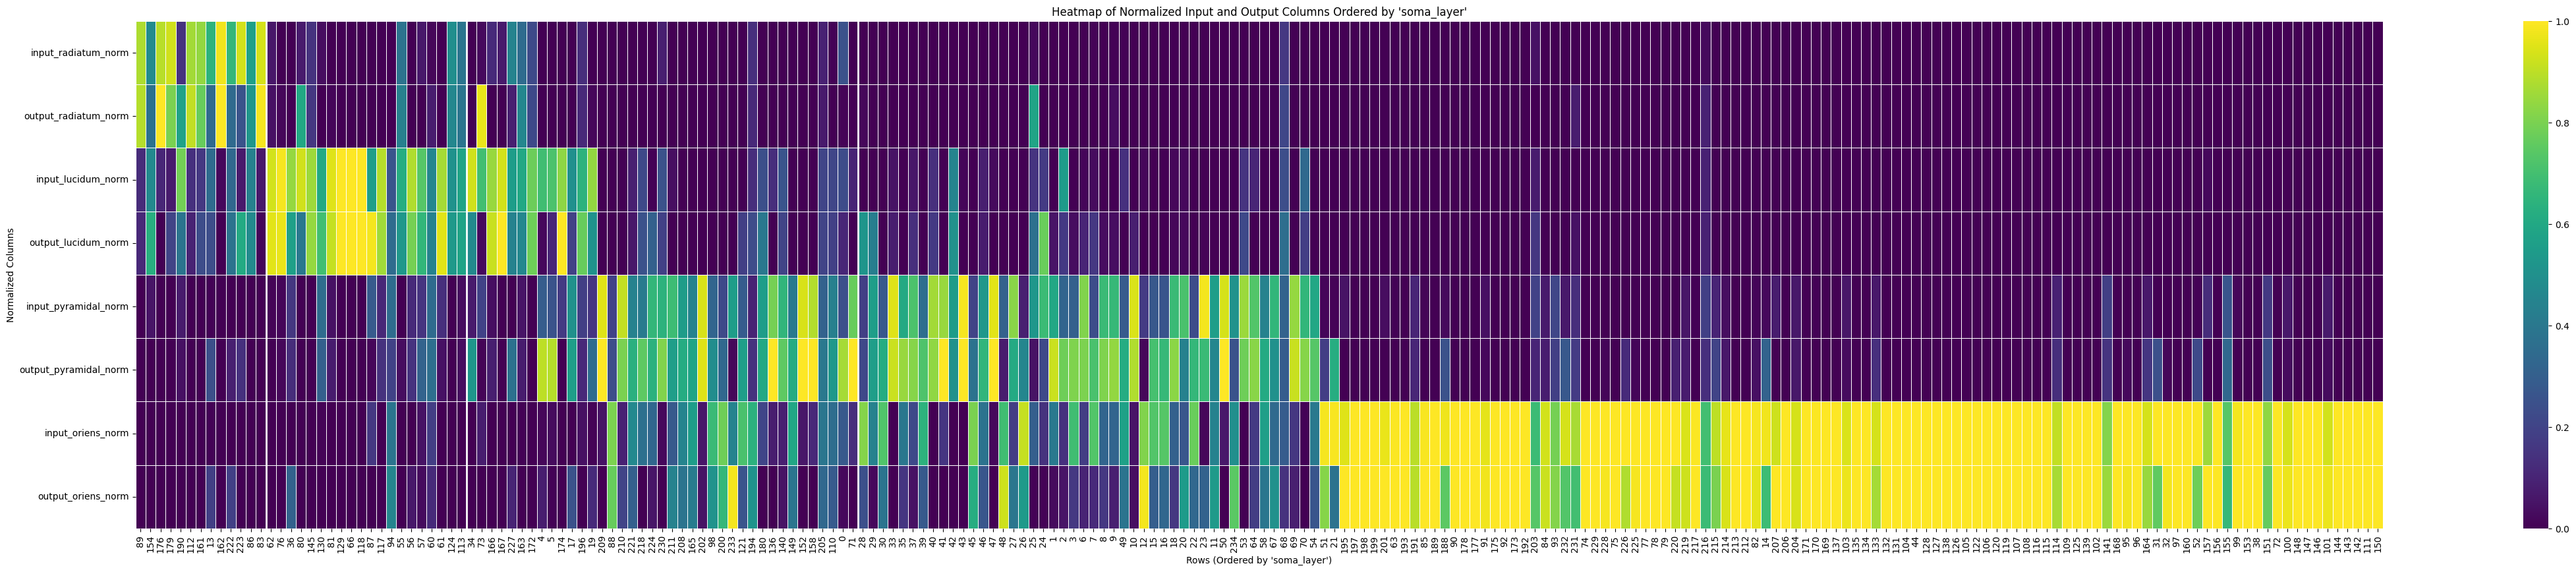

In [9]:
# Ensure the DataFrame is sorted by 'soma_layer' in the desired order
soma_order = ["radiatum", "lucidum", "pyramidal", "oriens"]
df_filtered['soma_layer'] = pd.Categorical(df_filtered['soma_layer'], categories=soma_order, ordered=True)
df_sorted = df_filtered.sort_values('soma_layer')

# Reorder the columns for the heatmap
heatmap_data = df_sorted[
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"]
]

# Confirm that the number of rows is 228
print("Number of rows in the data:", heatmap_data.shape[0])  # This should print 228

# Set up the figure
plt.figure(figsize=(55, 10))

# Plot the heatmap
ax = sns.heatmap(heatmap_data.T, cmap="viridis", cbar=True, linewidths=0.5)

# Add white lines at boundaries of each "soma_layer" group
for i, layer in enumerate(soma_order[:-1], 1):  # Skip last as no line needed at end
    layer_count = (df_sorted['soma_layer'] == layer).sum()
    ax.axvline(x=layer_count, color='white', linewidth=2)

# Set axis labels and titles
ax.set_xlabel("Rows (Ordered by 'soma_layer')")
ax.set_ylabel("Normalized Columns")
ax.set_yticklabels(["input_radiatum_norm", "output_radiatum_norm", 
                    "input_lucidum_norm", "output_lucidum_norm", 
                    "input_pyramidal_norm", "output_pyramidal_norm", 
                    "input_oriens_norm", "output_oriens_norm"], rotation=0)

plt.title("Heatmap of Normalized Input and Output Columns Ordered by 'soma_layer'")
plt.show()


Number of rows in the data: 224


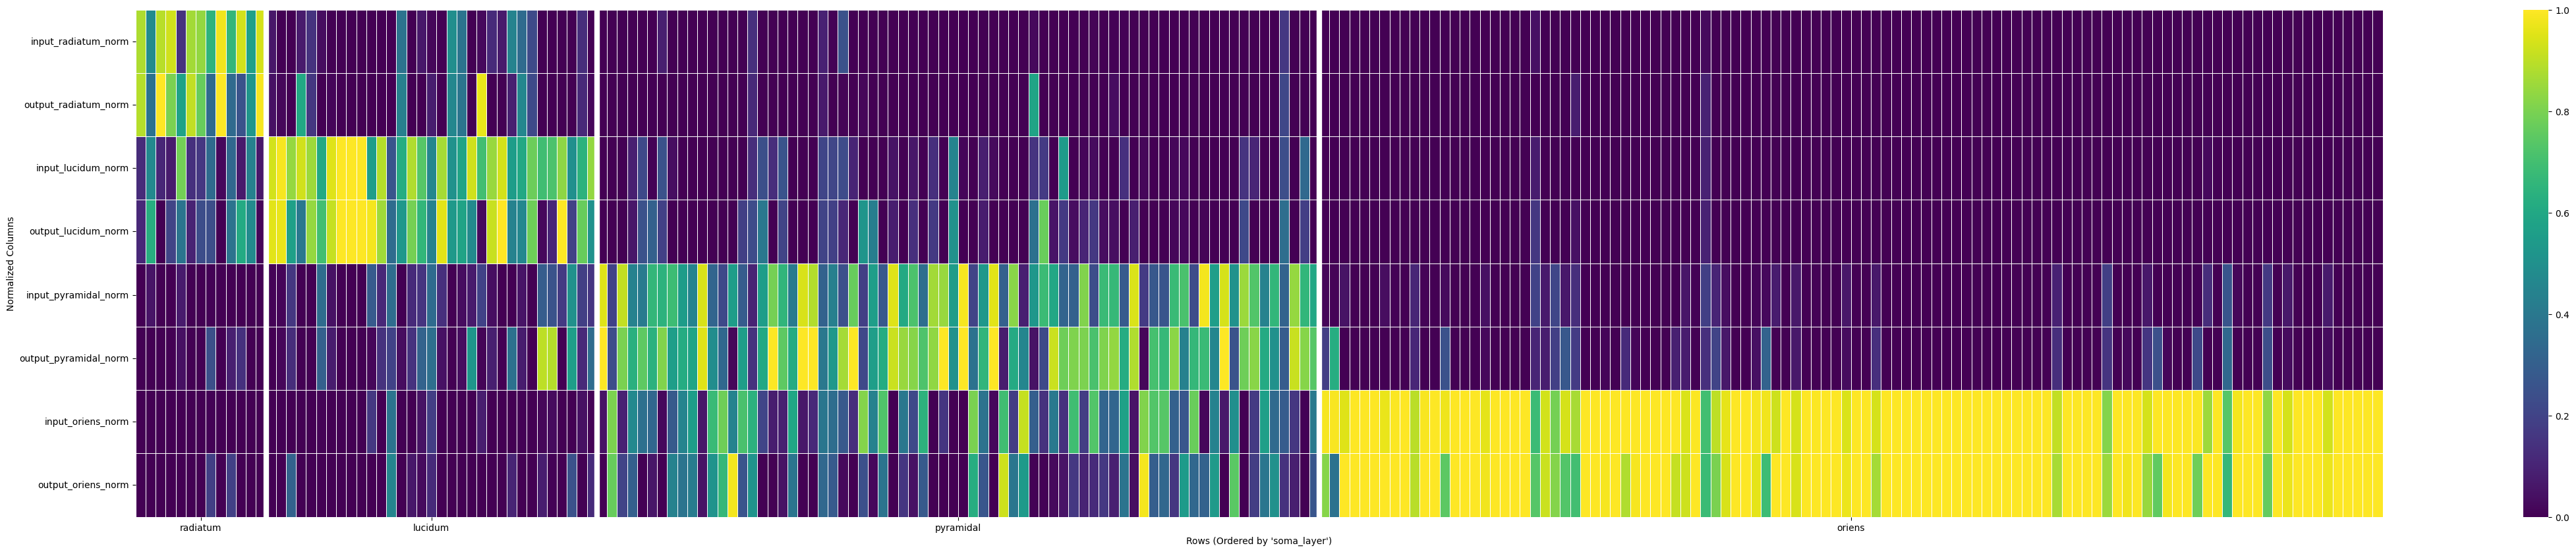

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

soma_order = ["radiatum", "lucidum", "pyramidal", "oriens"]
df_filtered['soma_layer'] = pd.Categorical(df_filtered['soma_layer'], categories=soma_order, ordered=True)
df_sorted = df_filtered.sort_values('soma_layer')
# Ensure the DataFrame is sorted by 'soma_layer' in the desired order
soma_order = ["radiatum", "lucidum", "pyramidal", "oriens"]
df_filtered['soma_layer'] = pd.Categorical(df_filtered['soma_layer'], categories=soma_order, ordered=True)
df_sorted = df_filtered.sort_values('soma_layer')

# Reorder the columns for the heatmap
heatmap_data = df_sorted[
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"]
]

# Confirm that the number of rows is 228
print("Number of rows in the data:", heatmap_data.shape[0])  # This should print 228

# Set up the figure
plt.figure(figsize=(55, 10))

# Plot the heatmap
ax = sns.heatmap(heatmap_data.T, cmap="viridis", cbar=True, linewidths=0.5)

# Calculate and plot white lines at boundaries of each "soma_layer" group, and set labels below
current_position = 0
x_labels = []
x_positions = []

for layer in soma_order:
    layer_count = (df_sorted['soma_layer'] == layer).sum()
    next_position = current_position + layer_count
    
    # Set midpoint for each category label
    x_labels.append(layer)
    x_positions.append((current_position + next_position) / 2)
    
    # Draw vertical line for group boundary
    if layer != soma_order[-1]:  # No line needed at the very end
        ax.axvline(x=next_position, color='white', linewidth=6)
        
    current_position = next_position

# Set axis labels and titles
ax.set_xlabel("Rows (Ordered by 'soma_layer')")
ax.set_ylabel("Normalized Columns")
ax.set_yticklabels(
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"], rotation=0
)

# Set custom x-axis labels for soma layers
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=0, ha='center')

plt.show()


Number of rows in the data: 224


ValueError: Image size of 90000x18000 pixels is too large. It must be less than 2^16 in each direction.

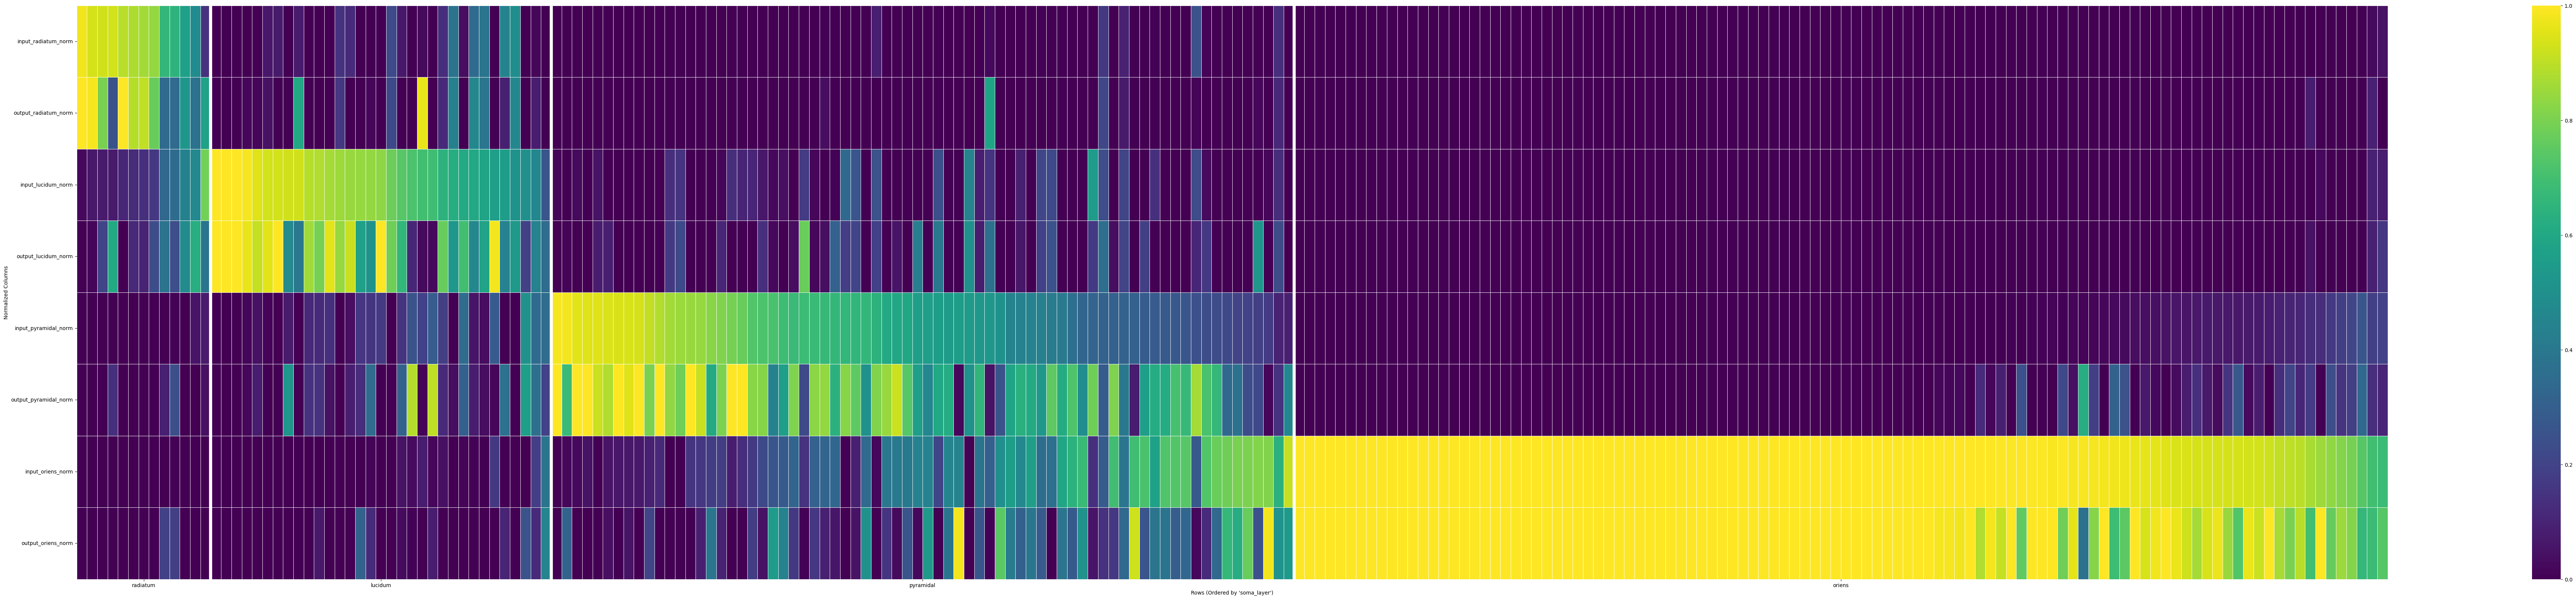

In [13]:
# Define custom sorting for each 'soma_layer'
# We will create a helper column to prioritize sorting order based on the specific norms for each layer.
df_filtered['sort_key'] = 0  # Initialize a helper column

# Apply different sorting rules within each soma layer
df_filtered.loc[df_filtered['soma_layer'] == 'radiatum', 'sort_key'] = df_filtered['input_radiatum_norm'] * 1e2 + df_filtered['output_radiatum_norm']
df_filtered.loc[df_filtered['soma_layer'] == 'lucidum', 'sort_key'] = df_filtered['input_lucidum_norm'] * 1e2 + df_filtered['output_lucidum_norm']
df_filtered.loc[df_filtered['soma_layer'] == 'pyramidal', 'sort_key'] = df_filtered['input_pyramidal_norm'] * 1e2 + df_filtered['output_pyramidal_norm']
df_filtered.loc[df_filtered['soma_layer'] == 'oriens', 'sort_key'] = df_filtered['input_oriens_norm'] * 1e2 + df_filtered['output_oriens_norm']

# Sort by 'soma_layer' first, then by the 'sort_key' column within each layer (in descending order)
df_sorted = df_filtered.sort_values(['soma_layer', 'sort_key'], ascending=[True, False])

# Reorder the columns for the heatmap
heatmap_data = df_sorted[
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"]
]

# Confirm that the number of rows is 228
print("Number of rows in the data:", heatmap_data.shape[0])  # This should print 228

# Set up the figure
plt.figure(figsize=(100, 20))

# Plot the heatmap
ax = sns.heatmap(heatmap_data.T, cmap="viridis", cbar=True, linewidths=0.5)

# Calculate and plot white lines at boundaries of each "soma_layer" group, and set labels below
current_position = 0
x_labels = []
x_positions = []

for layer in soma_order:
    layer_count = (df_sorted['soma_layer'] == layer).sum()
    next_position = current_position + layer_count
    
    # Set midpoint for each category label
    x_labels.append(layer)
    x_positions.append((current_position + next_position) / 2)
    
    # Draw vertical line for group boundary
    if layer != soma_order[-1]:  # No line needed at the very end
        ax.axvline(x=next_position, color='white', linewidth=6)
        
    current_position = next_position

# Set axis labels and titles
ax.set_xlabel("Rows (Ordered by 'soma_layer')")
ax.set_ylabel("Normalized Columns")
ax.set_yticklabels(
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"], rotation=0
)

# Set custom x-axis labels for soma layers
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=0, ha='center')
plt.savefig('heatmap_1.png', dpi=900)
plt.show()


Red box added for layer 'radiatum' at position 12 (index: 62.0).
Red box added for layer 'lucidum' at position 19 (index: 82.0).
Red box added for layer 'pyramidal' at position 91 (index: 164.0).
Red box added for layer 'oriens' at position 150 (index: 22.0).


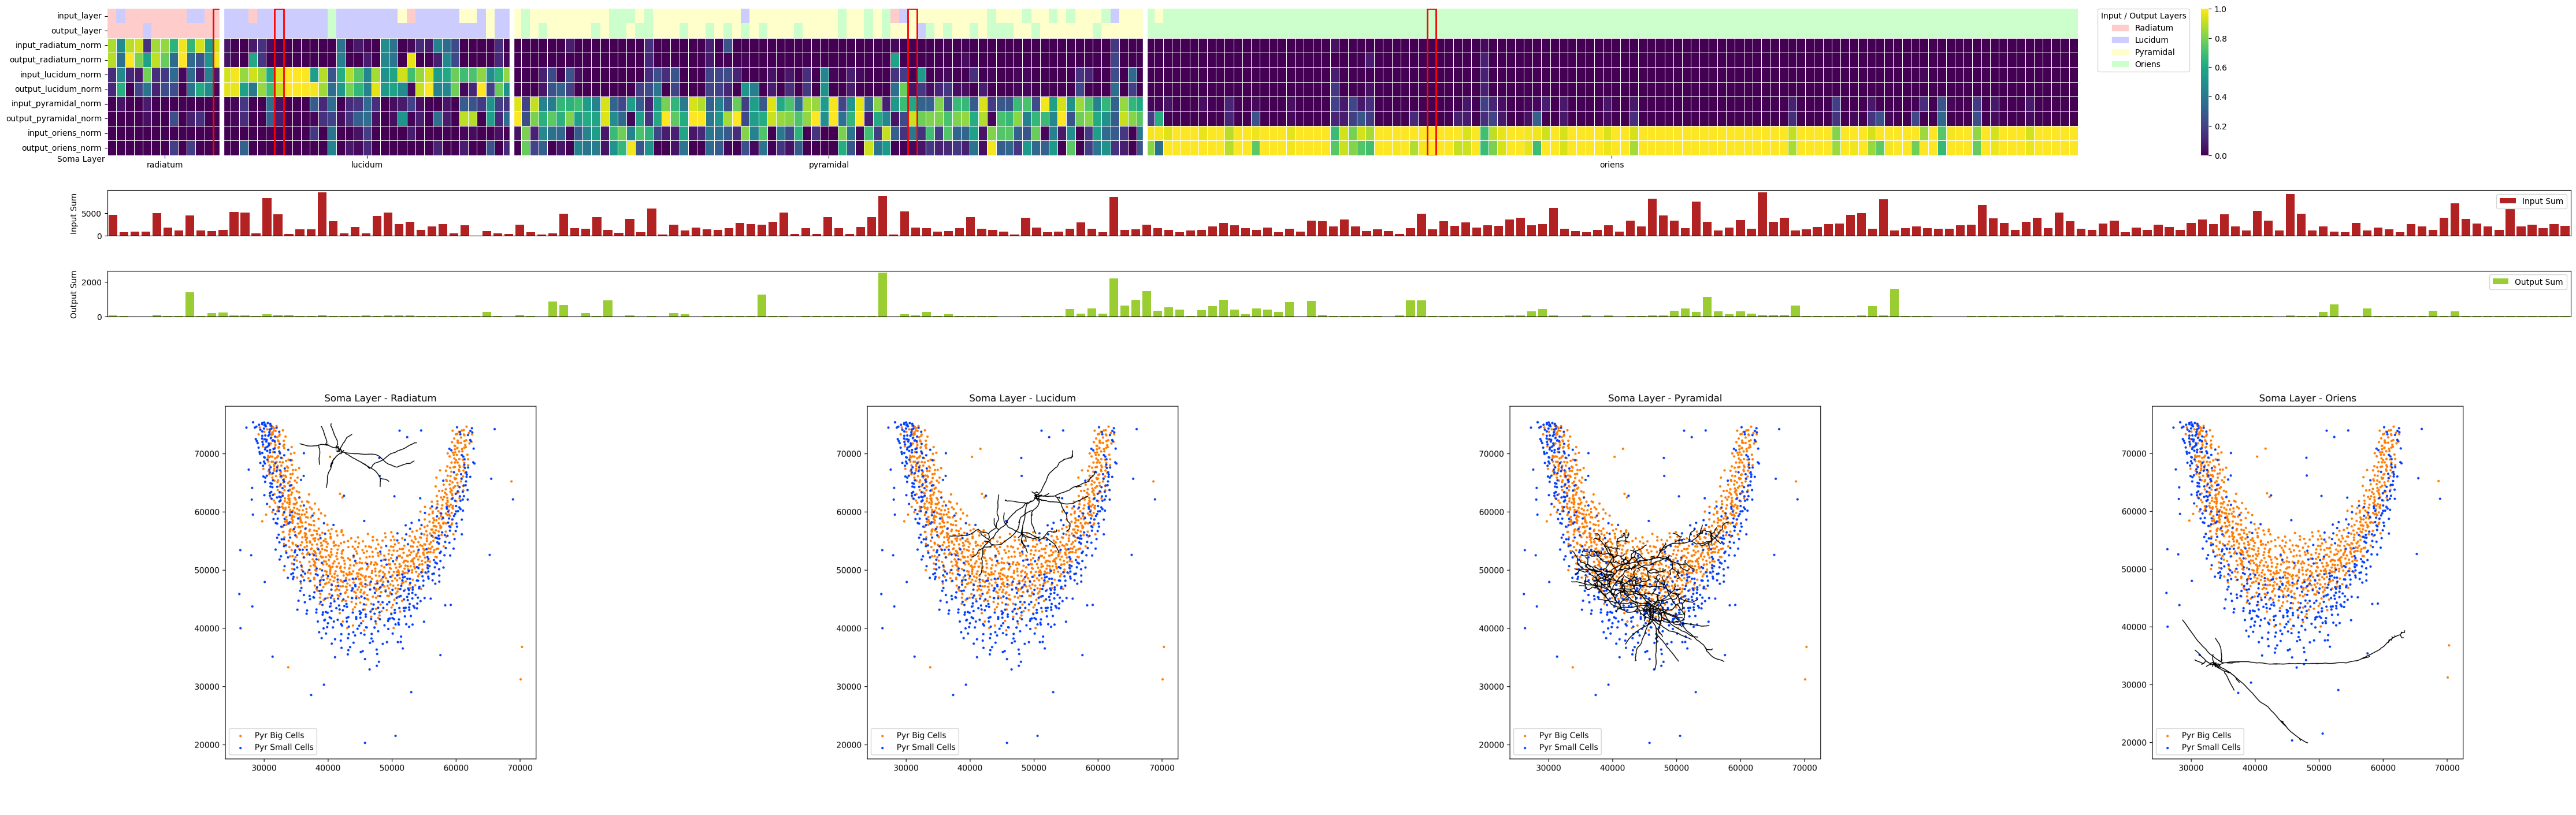

In [9]:
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

soma_order = ["radiatum", "lucidum", "pyramidal", "oriens"]
df_filtered['soma_layer'] = pd.Categorical(df_filtered['soma_layer'], categories=soma_order, ordered=True)
df_sorted = df_filtered.sort_values('soma_layer')

# Define pastel colors for each layer
layer_colors = {
    "radiatum": (1.0, 0.8, 0.8),  # pastel red
    "lucidum": (0.8, 0.8, 1.0),   # pastel blue
    "pyramidal": (1.0, 1.0, 0.8), # pastel yellow
    "oriens": (0.8, 1.0, 0.8)     # pastel green
}

# Reorder the columns for the heatmap
heatmap_data = df_sorted[
    ["input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"]
]

# Create dummy rows for 'input_layer' and 'output_layer' with value 1
input_layer_row = np.ones((1, len(df_sorted)))
output_layer_row = np.ones((1, len(df_sorted)))

# Convert heatmap_data to a matrix and stack with the extra rows at the top
heatmap_matrix = np.vstack([input_layer_row, output_layer_row, heatmap_data.values.T])


# Set up the figure with GridSpec for more control
fig = plt.figure(figsize=(55, 18))
gs = gridspec.GridSpec(4, 4, height_ratios=[16, 5, 5, 50], width_ratios=[1, 1, 1, 1])

# Create axes for heatmap, bar graphs, and scatterplots
heatmap_ax = fig.add_subplot(gs[0, :])  # Heatmap spans the entire first row
input_bar_ax = fig.add_subplot(gs[1, :])  # Input bar spans the entire second row
output_bar_ax = fig.add_subplot(gs[2, :])  # Output bar spans the entire third row

# Scatterplot graphs span the entire fourth row, divided into four equal parts
graph1_ax = fig.add_subplot(gs[3, 0])
graph2_ax = fig.add_subplot(gs[3, 1])
graph3_ax = fig.add_subplot(gs[3, 2])
graph4_ax = fig.add_subplot(gs[3, 3])

# Set up the figure with additional space for the bar graphs
#ig, axes = plt.subplots(4,4, figsize=(55, 18), gridspec_kw={'height_ratios': [16, 1.5, 1.5, 5]})
#heatmap_ax = axes[0,0]
#input_bar_ax = axes[1,0]
#output_bar_ax = axes[2,0]

# Create additional axes for the three new graphs
#graph1_ax = axes[3, 0]
#graph2_ax = axes[3, 1]
#graph3_ax = axes[3, 2]
#graph4_ax = axes[3, 3]

# Load and display the saved figures
img1 = mpimg.imread('scatterplot_publication_quality_rad.png')  # Path to the first saved figure
graph1_ax.imshow(img1)
graph1_ax.axis('off')  # Turn off axes for better display

img2 = mpimg.imread('scatterplot_publication_quality_luc.png')  # Path to the first saved figure
graph2_ax.imshow(img2)
graph2_ax.axis('off')  # Turn off axes for better display

img3 = mpimg.imread('scatterplot_publication_quality_pyr.png')  # Path to the first saved figure
graph3_ax.imshow(img3)
graph3_ax.axis('off')  # Turn off axes for better display

img4 = mpimg.imread('scatterplot_publication_quality_ori.png')  # Path to the first saved figure
graph4_ax.imshow(img4)
graph4_ax.axis('off')  # Turn off axes for better display

# Remove unused axes to prevent blank plots
#for ax in axes[0, 1:]:
#    fig.delaxes(ax)
#for ax in axes[1, 1:]:
#    fig.delaxes(ax)
#for ax in axes[2, 1:]:
#    fig.delaxes(ax)

# Create custom colormap and plot the heatmap
cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(heatmap_matrix, cmap=cmap, cbar=True, linewidths=0.5, ax=heatmap_ax)

# Overlay pastel colors for 'input_layer' and 'output_layer' rows
for i, soma_layer in enumerate(df_sorted['output_layer']):
    color = layer_colors[soma_layer]
    heatmap_ax.add_patch(patches.Rectangle((i, 0), 1, 1, color=color, ec='none'))  # input_layer row
for i, soma_layer in enumerate(df_sorted['input_layer']):
    color = layer_colors[soma_layer]    
    heatmap_ax.add_patch(patches.Rectangle((i, 1), 1, 1, color=color, ec='none'))  # output_layer row

    #. ------------------------------
    
# Map soma layers to their corresponding input columns
layer_column_map = {
    "radiatum": "input_radiatum_norm",
    "lucidum": "input_lucidum_norm",
    "pyramidal": "input_pyramidal_norm",
    "oriens": "input_oriens_norm"
}

# Iterate over each soma layer
for soma_layer, input_column in layer_column_map.items():
    # Filter the DataFrame for the current soma layer
    layer_df = df_sorted[df_sorted['soma_layer'] == soma_layer]

    if not layer_df.empty:
        # Calculate the 90th percentile for the input column in the current soma layer
        threshold = layer_df[input_column].quantile(0.5)

        # Filter rows that are in the top 10% for the input column
        top_10_percent_df = layer_df[layer_df[input_column] >= threshold]

        if not top_10_percent_df.empty:
            # From the top 10%, find the row with the highest input_sum
            max_index = top_10_percent_df['input_sum'].idxmax()
            max_position = df_sorted.index.get_loc(max_index)  # Convert to x-axis position
            corresponding_index = df_sorted.loc[max_index, 'index']  # Retrieve the value in the 'index' column

            # Add a red rectangle to highlight the column
            heatmap_ax.add_patch(
                patches.Rectangle(
                    (max_position, 0),  # (x, y) starting from the bottom of the heatmap
                    1,  # Width of one column
                    heatmap_matrix.shape[0],  # Height spanning the entire heatmap
                    edgecolor='red',  # Red border
                    facecolor='none',  # Transparent fill
                    linewidth=2,  # Border thickness
                    transform=heatmap_ax.transData  # Align with heatmap data
                )
            )

            # Print the index number for debugging and tracking
            print(f"Red box added for layer '{soma_layer}' at position {max_position} (index: {corresponding_index}).")
        else:
            print(f"No rows in the top 10% for input column '{input_column}' in layer '{soma_layer}'.")
    else:
        print(f"No data for layer '{soma_layer}'.")



            #. ------------------------------

# Calculate and plot white lines at boundaries of each "soma_layer" group, and set labels below
current_position = 0
x_labels = []
x_positions = []

for layer in soma_order:
    layer_count = (df_sorted['soma_layer'] == layer).sum()
    next_position = current_position + layer_count
    
    # Set midpoint for each category label
    x_labels.append(layer)
    x_positions.append((current_position + next_position) / 2)
    
    # Draw vertical line for group boundary
    if layer != soma_order[-1]:  # No line needed at the very end
        heatmap_ax.axvline(x=next_position, color='white', linewidth=6)
        
    current_position = next_position

# Set axis labels and titles
#heatmap_ax.set_xlabel("Rows (Ordered by 'soma_layer')")
#heatmap_ax.set_ylabel("Normalized Columns + Layer Indicators")
heatmap_ax.set_yticklabels(
    ["input_layer", "output_layer", 
     "input_radiatum_norm", "output_radiatum_norm", 
     "input_lucidum_norm", "output_lucidum_norm", 
     "input_pyramidal_norm", "output_pyramidal_norm", 
     "input_oriens_norm", "output_oriens_norm"], rotation=0
)

# Set custom x-axis labels for soma layers
heatmap_ax.set_xticks(x_positions)
heatmap_ax.set_xticklabels(x_labels, rotation=0, ha='center')
heatmap_ax.text(-3, 10.55, "Soma Layer", ha='center', va='bottom', fontsize=10, fontweight='normal')

# Adjust x_indices for proper alignment
x_indices = np.arange(len(df_sorted)) + 0.5  # Align with heatmap columns

# Plot input_sum bar graph
input_bar_ax.bar(x_indices, df_sorted['input_sum'], color='firebrick', label='Input Sum', width=0.8)
input_bar_ax.set_xlim(0, len(df_sorted))  # Match heatmap limits
input_bar_ax.set_ylabel('Input Sum')
input_bar_ax.legend()
input_bar_ax.set_xticks([])  # Hide x-tick labels to align with heatmap

# Plot output_sum bar graph
output_bar_ax.bar(x_indices, df_sorted['output_sum'], color='yellowgreen', label='Output Sum', width=0.8)
output_bar_ax.set_xlim(0, len(df_sorted))  # Match heatmap limits
output_bar_ax.set_ylabel('Output Sum')
output_bar_ax.legend()
output_bar_ax.set_xticks([])  # Hide x-tick labels to align with heatmap

# Add legend for pastel colors
legend_patches = [
    patches.Patch(color=layer_colors["radiatum"], label="Radiatum"),
    patches.Patch(color=layer_colors["lucidum"], label="Lucidum"),
    patches.Patch(color=layer_colors["pyramidal"], label="Pyramidal"),
    patches.Patch(color=layer_colors["oriens"], label="Oriens")
]

# Adjust the position using bbox_to_anchor
heatmap_ax.legend(
    handles=legend_patches, 
    loc='upper left',  # Position relative to the bbox anchor
    bbox_to_anchor=(1.01, 1),  # (x, y) coordinates in axes fraction
    borderaxespad=0,  # Padding between the legend and the axes
    title="Input / Output Layers"
)

